# Solution 01 Interest Rates Reinforcement Learning: Q-Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from solution_interest_rate_environment import *
import random

### Short Data Analysis
The first step we are doing is to explore the given data and have a short look at the contents of the csv file.

In [2]:
product_path = "../data/interest_rates_p1.csv"

# Load the csv file with pandas
interest_rates = pd.read_csv(product_path)

# Convert column timestamp into datetime objects
interest_rates['timestamp'] = pd.to_datetime(interest_rates["timestamp"])

# Calculate the avg with a rolling window
interest_rates['interest_rate_avg'] = interest_rates['interest_rate'].rolling(window=5, center=False).mean()

# Have a look at the top 10 entries
display(interest_rates.head(10))


# Display descriptive statistics using describe
display(interest_rates['interest_rate'].describe())
display(interest_rates['interest_rate_avg'].describe())

,timestamp,interest_rate,interest_rate_avg
0,2018-10-01 00:00:00,-0.000061,NaN
1,2018-10-01 04:00:00,0.000031,NaN
2,2018-10-01 08:00:00,-0.000051,NaN
3,2018-10-01 12:00:00,-0.000036,NaN
4,2018-10-01 16:00:00,-0.000015,-0.000027
5,2018-10-01 20:00:00,0.000066,-0.000001
6,2018-10-02 00:00:00,0.000124,0.000017
7,2018-10-02 04:00:00,0.000164,0.000060
8,2018-10-02 08:00:00,0.000233,0.000114
9,2018-10-02 12:00:00,0.000314,0.000180


count    4320.000000
mean        0.000014
std         0.000263
min        -0.002000
25%        -0.000104
50%         0.000017
75%         0.000143
max         0.002000
Name: interest_rate, dtype: float64

count    4316.000000
mean        0.000014
std         0.000232
min        -0.001909
25%        -0.000094
50%         0.000014
75%         0.000134
max         0.001261
Name: interest_rate_avg, dtype: float64

### Visualize interest rates
In the next step we would like to visualize the given data to get an overview.

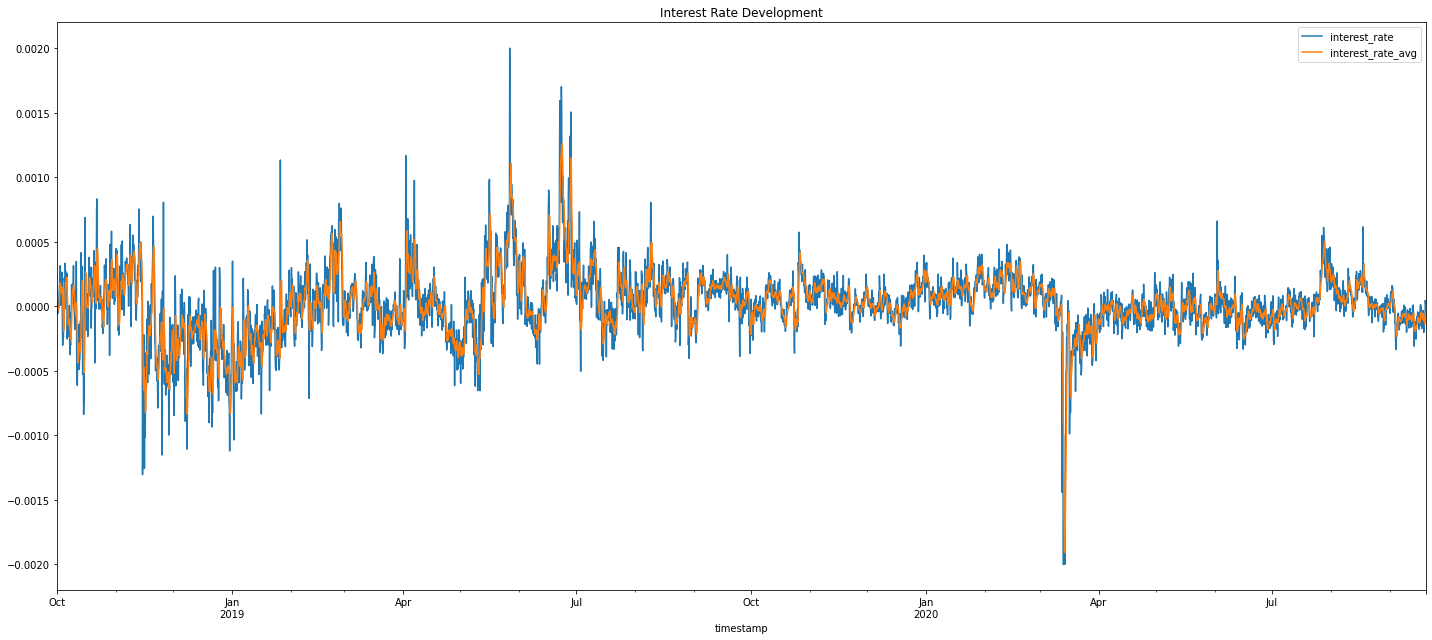

In [3]:
interest_rates.plot(x="timestamp", y=["interest_rate", "interest_rate_avg"], legend=True, figsize=(20,9))

plt.title("Interest Rate Development")
plt.tight_layout()
plt.show()

### Create environment for Q-Learning

Now we are ready to create an instance of our previously created environment and execute a view steps in the environment.

In [4]:
# Create an interest rate environment with the path of the csv file and optional start/end date
env = InterestRateEnv(product_path, end = '2020-01-01')

# Display statistics from interest_rate and normamlized_interest_rate_avg
display(env.df_interest_rates['interest_rate'].describe())
display(env.df_interest_rates['normalized_interest_rate_avg'].describe())

count    2738.000000
mean        0.000021
std         0.000290
min        -0.001305
25%        -0.000127
50%         0.000027
75%         0.000167
max         0.002000
Name: interest_rate, dtype: float64

count    2738.000000
mean        0.010582
std         0.126937
min        -0.417646
25%        -0.058311
50%         0.013033
75%         0.076474
max         0.630356
Name: normalized_interest_rate_avg, dtype: float64

In [5]:
# Getting the action and observation space
print("Action Space: {}".format(env.action_space))
print("Observation Space: {}".format(env.observation_space))

# Reset environment and output first observation
first_observation = env.reset()
print("First Observation: {}".format(first_observation))

Action Space: Discrete(3)
Observation Space: Discrete(40)
First Observation: 20


In [6]:
# Execute a view random actions and print observation, reward, done, info and position
for _ in range(5):
    env.render()
    action = env.action_space.sample()
    print("Action: " + str(action))
    observation, reward, done, info = env.step(action)
    print("Observation: " +str(observation))
    print("Reward: " + str(reward))
    print("Done: " + str(done))
    print("Info: " + str(info))
    print("Position: " + str(env.current_position))
    print("")

Current value: 1.000
Action: 1
Observation: 19
Reward: 0.0
Done: False
Info: {'timestamp': numpy.datetime64('2018-10-01T20:00:00.000000000'), 'value': 1.0, 'position': 0, 'interest_rate': -1.5473779166668e-05}
Position: 0

Current value: 1.000
Action: 1
Observation: 20
Reward: 0.0
Done: False
Info: {'timestamp': numpy.datetime64('2018-10-02T00:00:00.000000000'), 'value': 1.0, 'position': 0, 'interest_rate': 6.5502520833332e-05}
Position: 0

Current value: 1.000
Action: 0
Observation: 20
Reward: -0.0007502813907041774
Done: False
Info: {'timestamp': numpy.datetime64('2018-10-02T04:00:00.000000000'), 'value': 0.99925, 'position': -1, 'interest_rate': 0.0001237357666666}
Position: -1

Current value: 0.999
Action: 1
Observation: 21
Reward: -0.0009143027206337209
Done: False
Info: {'timestamp': numpy.datetime64('2018-10-02T08:00:00.000000000'), 'value': 0.9983368005403976, 'position': 0, 'interest_rate': 0.0001640078791666}
Position: 0

Current value: 0.998
Action: 2
Observation: 21
Reward:

## Helper methods

In [7]:
def get_model(env):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    return Q

# Function that plots the development of the portfolio value within one episode
def plot_developments(statuses):   
    ax = statuses.plot(x="timestamp", y=["position", "value", "cum_interest_rate"], secondary_y=['position'], legend=True, figsize=(16,9), title="Performance of trained agent on evaluation data")
    ax.set_ylim([0.5,1.2])
    plt.tight_layout()
    plt.show()
    
def highlight_max(s): 
    is_max = s == s.max() 
    return ['background: lightgreen' if cell else '' for cell in is_max]

## Q-Learning
Now we are ready to start with the actual implementation of our Q-Learning algorithm.

In [8]:
#Initializing the Q-table
print("Action space: " + str(env.action_space.n))
print("Observation space: " + str(env.observation_space.n))
Q = get_model(env)
print("Q-table shape: " + str(Q.shape))

Action space: 3
Observation space: 40
Q-table shape: (40, 3)


In [9]:
# Have a look how interest rates are converted to states and vice versa
print(env.get_state_for_interest_rate(-0.97))
print(env.get_state_for_interest_rate(0.95))
print(env.get_interest_rate_for_state(1))
print(env.get_interest_rate_for_state(39))

0
39
-0.95
0.95


In [10]:
# Training the agent

def train_q_learning(env, train_episodes=100):
    
    # Setting the parameters for Q-Learning 
    gamma = 0.7  # discount factor
    alpha = 0.7  # learning rate                           
    epsilon = 1             
    nr_steps = env.maximum_episode_steps()

    # max_epsilon, min_epsilon and decay are used for a decayed epsilon greedy approach
    max_epsilon = 1
    min_epsilon = 0.01         
    decay = 0.01
    
    # Keep track of portfolio value and epsilon in each episode
    epsilons = []
    portfolio_values = []
    
    Q = get_model(env)
    
    for episode in range(train_episodes):
        # Reset the environment at every episode
        state = env.reset()    

        for step in range(nr_steps):
            # TODO Implement Q-Learning

            # Choose an action based on a random number and the given epsilon: Option 1 is to eploit, Option 2 is to explore
            random_tradeoff = random.uniform(0, 1)
            
            # Exploit
            if random_tradeoff > epsilon:
                action = np.argmax(Q[state,:]) 

            # Explore
            else:
                action = env.action_space.sample()

            # Perform the action
            new_state, reward, done, info = env.step(action)

            # Update the Q-Table using the Bellman equation
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

            # Update the state
            state = new_state

            # End the epsiode if done is true
            if done == True:
                break

        # Decayed epsilon greedy: Cutting down on exploration by reducing the epsilon in each episode
        # TODO (see slides for further information)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

        # Add the portfolio value to list of portfolio values
        portfolio_values.append(env.current_value)

        # Add epsilon to list of epsilons
        epsilons.append(epsilon)

        print("Finished episode {}".format(episode))

    print ("Avg. training score: " + str(sum(portfolio_values)/train_episodes))
    return Q, portfolio_values, epsilons

### Training phase

In [11]:
train_episodes = 200
Q, portfolio_values, epsilons = train_q_learning(env, train_episodes=train_episodes)

Finished episode 0
Finished episode 1
Finished episode 2
Finished episode 3
Finished episode 4
Finished episode 5
Finished episode 6
Finished episode 7
Finished episode 8
Finished episode 9
Finished episode 10
Finished episode 11
Finished episode 12
Finished episode 13
Finished episode 14
Finished episode 15
Finished episode 16
Finished episode 17
Finished episode 18
Finished episode 19
Finished episode 20
Finished episode 21
Finished episode 22
Finished episode 23
Finished episode 24
Finished episode 25
Finished episode 26
Finished episode 27
Finished episode 28
Finished episode 29
Finished episode 30
Finished episode 31
Finished episode 32
Finished episode 33
Finished episode 34
Finished episode 35
Finished episode 36
Finished episode 37
Finished episode 38
Finished episode 39
Finished episode 40
Finished episode 41
Finished episode 42
Finished episode 43
Finished episode 44
Finished episode 45
Finished episode 46
Finished episode 47
Finished episode 48
Finished episode 49
Finished e

### Display learned Q-Table
Now we will have a look at the different Q-values

In [12]:
# Create a dataframe for Q-Table
q_df = pd.DataFrame(Q, columns= ['SHORT', 'NO_POSITION', 'LONG'])
q_df.reset_index(inplace=True)
q_df['index'] = q_df['index'].apply(lambda x : env.get_interest_rate_for_state(x))
q_df.rename(columns={'index': 'interest_rate'}, inplace=True)

# Highlight highest value per row in lightgreen
q_df = q_df.style.apply(highlight_max, axis=1, subset = q_df.columns[1:4])
display(q_df)

# Print columns with maximum value per row
print(np.argmax(Q, axis=1))

,interest_rate,SHORT,NO_POSITION,LONG
0,-1.000000,0.000000,0.000000,0.000000
1,-0.950000,0.000000,0.000000,0.000000
2,-0.900000,0.000000,0.000000,0.000000
3,-0.850000,0.000000,0.000000,0.000000
4,-0.800000,0.000000,0.000000,0.000000
5,-0.750000,0.000000,0.000000,0.000000
6,-0.700000,0.000000,0.000000,0.000000
7,-0.650000,0.000000,0.000000,0.000000
8,-0.600000,0.000000,0.000000,0.000000
9,-0.550000,0.000000,0.000000,0.000000


[0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 1 1 1 1 2 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0]


### Visualize results and total portfolio values over all episodes

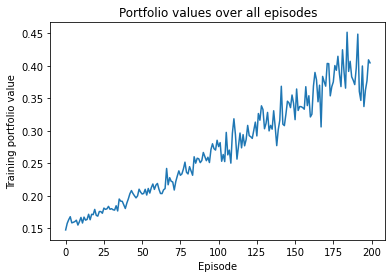

In [13]:
x = range(train_episodes)
plt.plot(x, portfolio_values)
plt.xlabel('Episode')
plt.ylabel('Training portfolio value')
plt.title('Portfolio values over all episodes') 
plt.show()

### Visualize the epsilons over all episodes

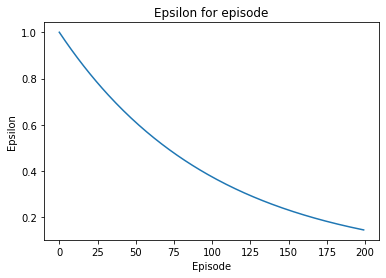

In [14]:
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

### Testing the agent
Now we would like to test our reinforcement learning agent and therefore execute one episode where we always choose the "best" action, based on the learned Q-values.
Think about how to split training and test data. The data which was used for the training, should not be used for test.
Options are to specify an end date for training and a start date for test, or to use interest rates of a different product.


In [15]:
def test_agent(env, Q):
    # Reset the environment
    state = env.reset()    
    infos = []
    done = False

    while not done:
        # No position if all Q values are equal
        all_equal = len(set(Q[state])) <= 1
        if all_equal:
            action = 1
        else:
            # Use the "best" action based on the previously calculated q-table
            action = np.argmax(Q[state,:])

        # Execute one step
        state, reward, done, info = env.step(action)
        infos.append(info)

        # End the episode if done = True
        if done == True:
            break

    print("Final portfolio value: " + str(env.current_value))
    return infos
    

In [16]:
#Testing the agent
env = InterestRateEnv(product_path, start= '2020-01-01')
infos = test_agent(env, Q)


Final portfolio value: 0.8689216594589441


### Display portfolio development

            timestamp     value  position  interest_rate  cum_interest_rate
0 2020-01-02 00:00:00  0.999250         1       0.000208           1.000208
1 2020-01-02 04:00:00  0.998683         0       0.000183           1.000391
2 2020-01-02 08:00:00  0.998683         0       0.000222           1.000613
3 2020-01-02 12:00:00  0.998683         0       0.000149           1.000761
4 2020-01-02 16:00:00  0.998683         0       0.000184           1.000945


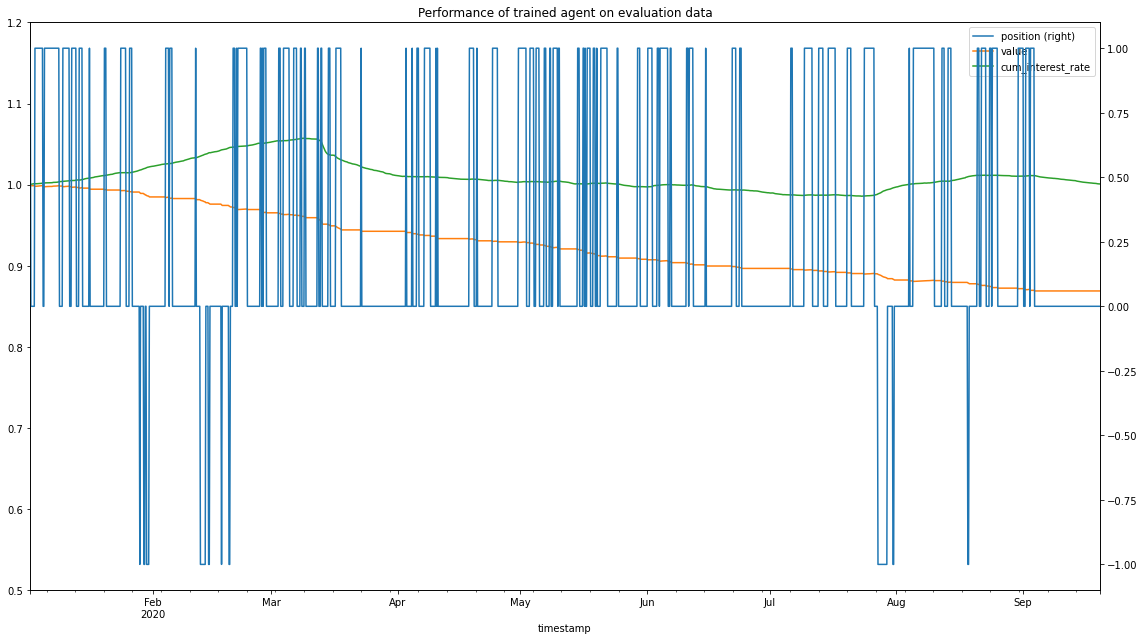

In [17]:
# Create a data frame with all the statues
info_df = pd.DataFrame.from_dict(infos)
info_df["cum_interest_rate"] = (info_df["interest_rate"] + 1).cumprod()

print(info_df[:5])

# Plot the portfolio developments and the positions over the testing time
plot_developments(info_df)